In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression, LassoCV, Lasso, Ridge, RidgeCV, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import lilliefors
from scipy import stats

SEED = 23

In [49]:
def normality_tests(data):
    """
    Perform various statistical tests to assess the normality of a given dataset.

    This function conducts the following normality tests on the provided data:
    1. Shapiro-Wilk Test
    2. Kolmogorov-Smirnov Test
    3. Anderson-Darling Test
    4. Lilliefors Test
    5. D’Agostino’s K-squared Test

    Each test provides different insights into the normality of the distribution 
    of the dataset. The function prints the test statistic and p-value for each test.

    Parameters:
    data (array-like): A sequence of numerical data points. The data should be a 1D array-like 
                       structure (e.g., Python list, NumPy array, or Pandas Series).

    Returns:
    None: This function only prints the results of the normality tests to the console.
    """
    
    # Shapiro-Wilk Test
    shapiro_stat, shapiro_p = stats.shapiro(data)
    print(f'Shapiro-Wilk Test: Statistic={shapiro_stat}, p-value={shapiro_p}')

    # Kolmogorov-Smirnov Test
    ks_stat, ks_p = stats.kstest((data - np.mean(data)) / np.std(data), 'norm')
    print(f'Kolmogorov-Smirnov Test: Statistic={ks_stat}, p-value={ks_p}')

    # Anderson-Darling Test
    anderson_result = stats.anderson(data, dist='norm')
    print(f'Anderson-Darling Test: Statistic={anderson_result.statistic}')
    for i in range(len(anderson_result.critical_values)):
        sl, cv = anderson_result.significance_level[i], anderson_result.critical_values[i]
        print(f'At a significance level of {sl}, the critical value is {cv}.')

    # Lilliefors Test
    lilliefors_stat, lilliefors_p = lilliefors(data)
    print(f'Lilliefors Test: Statistic={lilliefors_stat}, p-value={lilliefors_p}')

    # D’Agostino’s K-squared Test
    dagostino_stat, dagostino_p = stats.normaltest(data)
    print(f"D'Agostino's K-squared Test: Statistic={dagostino_stat}, p-value={dagostino_p}")

In [50]:
def Winsorization_Method(df_source, columns,  lower, upper):
    """
    Remove outliers from the given DataFrame based on the provided lower and upper percentiles.

    Parameters:
    -----------
    df_source : pandas.DataFrame
        The original DataFrame from which outliers will be removed.
    columns : list of str
        The names of the columns to consider for outlier removal.
    lower : float
        The lower percentile below which data points are considered as outliers.
    upper : float
        The upper percentile above which data points are considered as outliers.

    Returns:
    --------
    ratio : float
        The ratio of outliers in the original DataFrame, rounded to two decimal places.
    df_win : pandas.DataFrame
        A new DataFrame with the outliers removed.
    
    Example:
    --------
    >>> ratio, df_win = Winsorization_Method(df, ['A', 'B'], 10, 90)
    
    Notes:
    ------
    - The function makes a copy of the original DataFrame, so the original DataFrame remains unchanged.
    - Outliers are determined separately for each column and are not considered across multiple columns.

    """
    #Data preparation
    df = df_source.copy()
    df = df[columns]

    #Determining records with outliers
    outliers=[]
    
    for col in columns:
        q1 = np.percentile(df[col], lower)
        q2 = np.percentile(df[col], upper)
        
        for pos in range(len(df)):
            if df[col].iloc[pos]>q2 or df[col].iloc[pos]<q1:
                outliers.append(pos) 
                
    outliers = set(outliers)                   
    outliers = list(outliers)
    
    ratio= round(len(outliers)/len(df)*100, 2) #calculating the ratio of outliers in the original data                     
    df_win = df.drop(df.index[outliers]) 
    
    return ratio, df_win

In [51]:
def Standard_Outlier_Remover(df_source, num_cols, num_std=3): 
    """
    Remove outliers from specified numeric columns in a DataFrame.
    
    Parameters:
    -----------
    df_source : pandas DataFrame
        The original DataFrame from which to remove outliers.
    num_cols : list of str
        List of column names in df_source that are numeric and should be checked for outliers.
    num_std : int or float, optional
        The number of standard deviations to use for defining outliers. Default is 3.
        
    Returns:
    --------
    df_win : pandas DataFrame
        A new DataFrame with outliers removed.
    ratio : float
        The percentage of observations in the original DataFrame that were identified as outliers.
    outliers : list of int
        List of row indices in the original DataFrame that were identified as outliers.
    """
    
    df = df_source.copy()
    
    outliers = []
    
    for col in num_cols:
        mean = df[col].mean()
        std = df[col].std()
        tol = num_std * std
        upper = mean + tol
        lower = mean - tol
        
        # Using vectorized operations to find outliers
        outlier_mask = (df[col] > upper) | (df[col] < lower)
        outliers.extend(df.index[outlier_mask])
        
    # Remove duplicates
    outliers = list(set(outliers))
    
    # Calculate ratio of outliers
    ratio = round(len(outliers) / len(df) * 100, 2)
    
    # Drop outliers
    df_win = df.drop(index=outliers)
    
    return df_win, ratio, outliers

In [52]:
def high_corr(df_source, method='spearman', thsld=0.8, perc=0.95):
    """
    Remove columns from a DataFrame that are highly correlated with other columns.

    Parameters:
    -----------
    df_source : pandas.DataFrame
        The original DataFrame for which to identify and remove highly correlated columns.

    method : str, optional
        The correlation method to be used. 'pearson', 'kendall', 'spearman' are supported. 
        Default is 'spearman'.

    thsld : float, optional
        The absolute correlation threshold. Pairs of columns with correlation higher than this value 
        will be considered for removal. Default is 0.8.

    perc : float, optional
        The percentile to use for deciding which variable to remove from a highly correlated pair.
        Should be between 0 and 1. Default is 0.95.

    Returns:
    --------
    df : pandas.DataFrame
        A new DataFrame with highly correlated columns removed.
    to_delete: list
        A list of removed variables. 

    Notes:
    ------
    - For each pair of highly correlated columns, the function removes the one with the higher
      percentile value of correlation, based on the 'perc' parameter.
    - Prints out the columns that are removed and their percentile values.
    """
    df =  df_source.copy()
    corr = df.corr(method)
    high_corr_vars = []
    to_delete = [] 
    for i in range(len(corr.columns)):
        for j in range(i):
            if abs(corr.iloc[i, j]) > thsld:
                colname_i = corr.columns[i]
                colname_j = corr.columns[j]

                # Calculate correlation for each variable
                perc_i = np.percentile(corr[colname_i], perc)
                perc_j = np.percentile(corr[colname_j], perc)

                # Decide which variable to remove from each correlated pair based on its highest percentile value in the correlation matrix.
                max_abs_value = max(abs(perc_i), abs(perc_j))
                if max_abs_value >= thsld:
                    if abs(perc_i) > abs(perc_j):
                        high_corr_vars.append((colname_i, perc_i))
                    else:
                        high_corr_vars.append((colname_j, perc_j))
                else:
                    if abs(perc_i) <= abs(perc_j):
                        high_corr_vars.append((colname_i, perc_i))
                    else:
                        high_corr_vars.append((colname_j, perc_j))

                    

    # Remove the variable with the highest mean correlation from each pair
    for var, perc_val in high_corr_vars:
        if var in df.columns:
            print(f"Removing {var} with {perc}th percentile = {perc_val}")
            del df[var]
            to_delete.append(var)
    print("Remaining columns:", df.columns)
    return df, to_delete

In [53]:
def linreg_p_values(model, X, y):
    # Fit the model
    model.fit(X, y)

    # Estimated coefficients
    coefficients = model.coef_

    # Predictions and Residuals
    predictions = model.predict(X)
    residuals = y - predictions

    # Degrees of freedom
    df = len(y) - 2

    # Sum of the residuals squared
    rss = np.sum(residuals**2)

    # Standard Error of coefficients
    stderr = np.sqrt(rss / df) / np.sqrt(np.sum((X - np.mean(X))**2))

    # t-statistics
    t_stat = coefficients / stderr

    # p-values
    p_values = [2 * (1 - stats.t.cdf(np.abs(t), df)) for t in t_stat]
    
    #Aggregation
    data = {'Predictor': X.columns, 'coef': list(coefficients), \
            't-stat': list(t_stat), 'p-values': p_values}
    final_df = pd.DataFrame(data)
    return final_df

# Data import and basic analysis

In [54]:
# Load Boston housing dataset
housing = fetch_california_housing()
X = pd.DataFrame(housing.data, columns=housing.feature_names)
y = pd.Series(housing.target)
df = pd.concat([X, y], axis=1).rename(columns={0:'Value'})

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   Value       20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [56]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Value
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


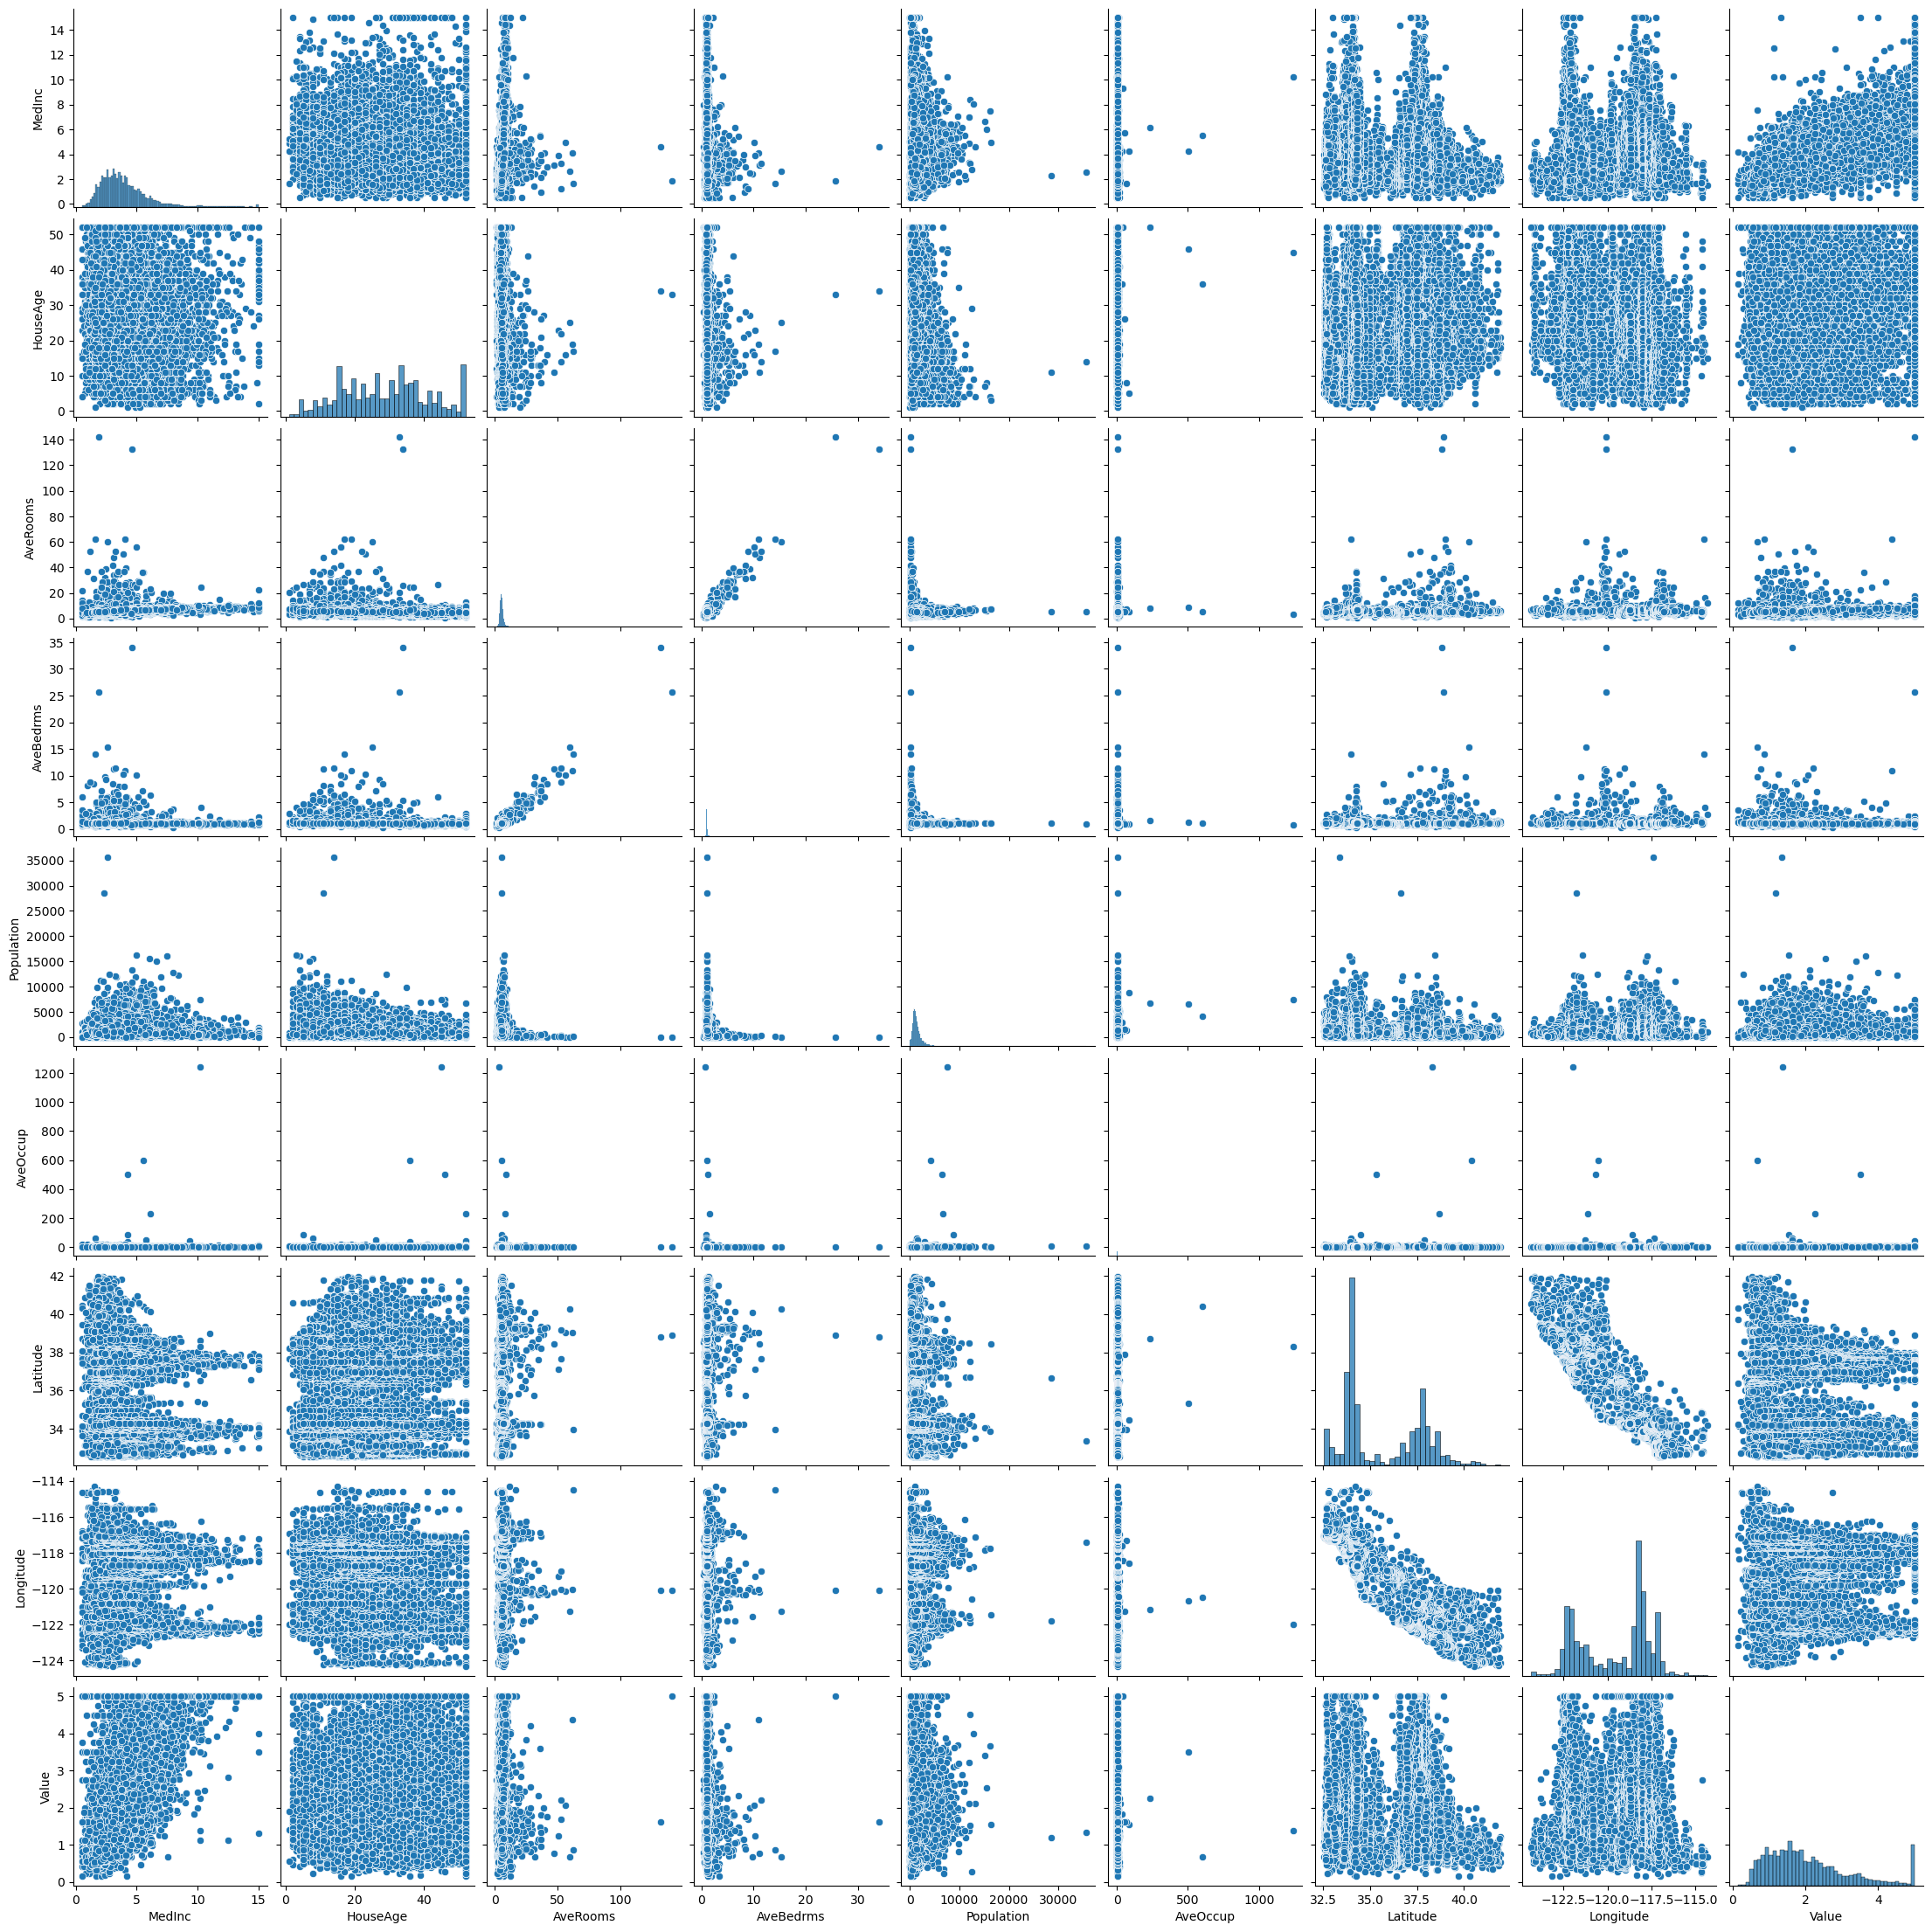

In [57]:
sns.pairplot(df)

In [58]:
#Cutting the outliers

df_std, ratio_std, outliers = Standard_Outlier_Remover(df, df.columns, 2)
print(f"Ratio of Outliers by Standard_Outlier_Remover:{ratio_std}")

Ratio of Outliers by Standard_Outlier_Remover:15.55


<AxesSubplot:>

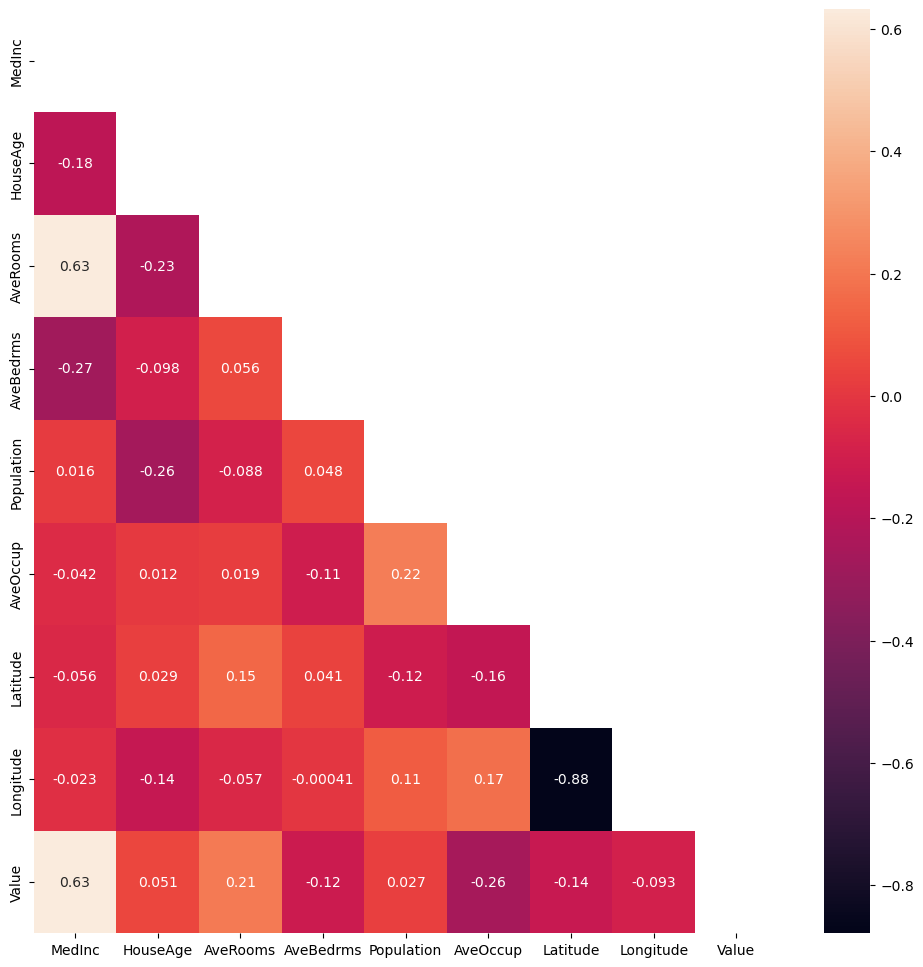

In [59]:
#calculating correlation matrix

corr = df_std.corr('spearman')
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corr, mask=mask, annot = True)

In [60]:
df_corr, corr_drop = high_corr(df, method='spearman', thsld=0.8, perc=0.9)

Removing Latitude with 0.9th percentile = -0.8278334719496386
Remaining columns: Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Longitude', 'Value'],
      dtype='object')


# Feature selection and transformation

In [61]:
# Using LassoCV for feature selection
lasso = LassoCV(cv=5).fit(X, y)
lasso_drop = list(X.columns[lasso.coef_ == 0])
print("Features dropped by LassoCV:", lasso_drop)

Features dropped by LassoCV: ['AveBedrms']


In [62]:
X_train, X_test, y_train, y_test= train_test_split(df_std.drop(corr_drop+lasso_drop+['Value']
                                                    , axis=1)
                                                    , df_std["Value"],test_size=0.1
                                                    , shuffle = True, random_state=SEED)

In [63]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Linear Regression

In [64]:
regressor = LinearRegression()
regressor.fit(X_train_std, y_train)
y_pred = regressor.predict(X_test_std)
y_pred_train = regressor.predict(X_train_std)
residuals = y_test - y_pred

In [65]:
train_scores = cross_val_score(regressor, X_train_std, y_train, cv=5, scoring='neg_mean_squared_error')
test_mse = mean_squared_error(y_test, y_pred)
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred)

print("Average train MSE:", -np.mean(train_scores))
print(f'Test MSE: {test_mse}')
print(f'Train MAE: {train_mae}')
print(f'Test MAE: {test_mae}')
print(f'Train coefficient of determination: {train_r2}')
print(f'Test coefficient of determination: {test_r2}')

Average train MSE: 0.38352913514687836
Test MSE: 0.3768228082076953
Train MAE: 0.4739993090436294
Test MAE: 0.4756508997848135
Train coefficient of determination: 0.5054143779562092
Test coefficient of determination: 0.5053847306627732


# Assumptions testing

## Linear relarionship

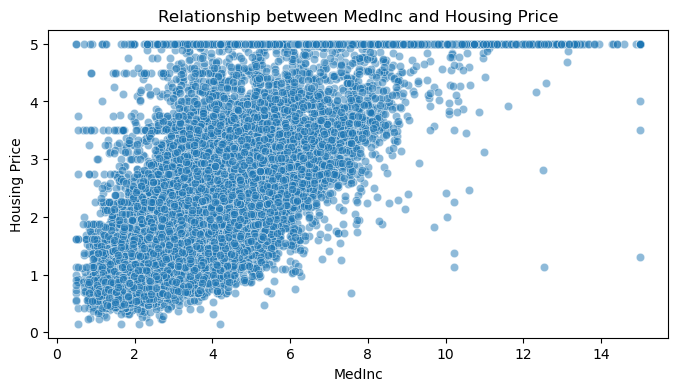

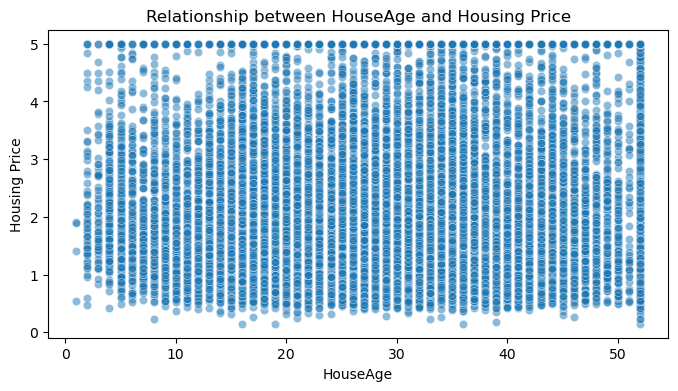

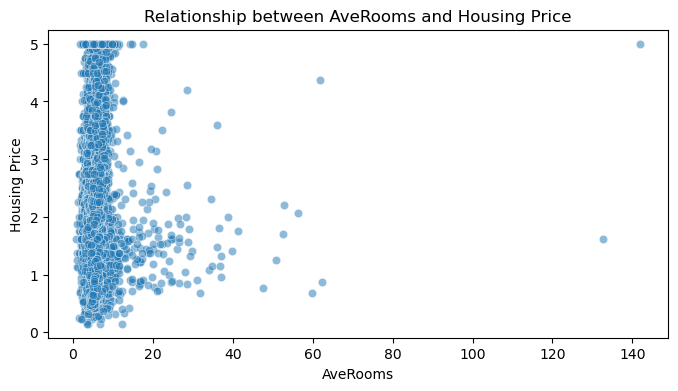

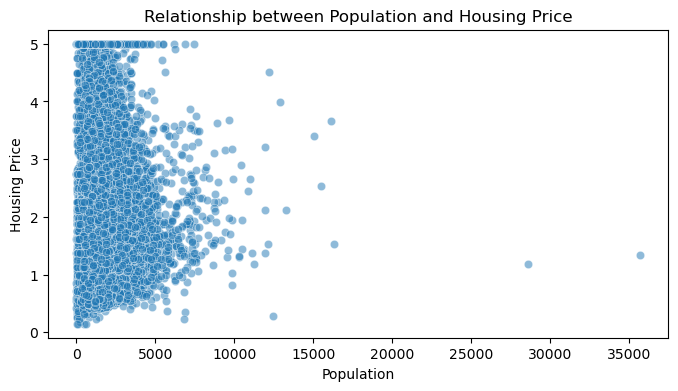

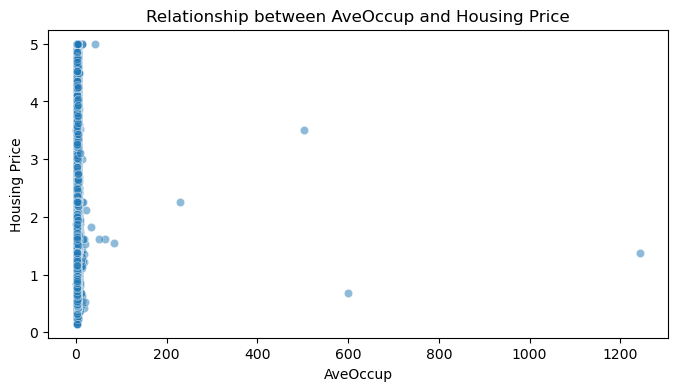

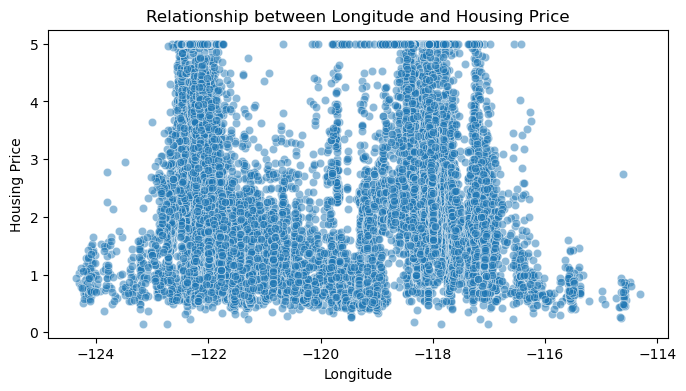

In [66]:
for column in X_train.columns:
    plt.figure(figsize=(8, 4))
    sns.scatterplot(data = df, x=column, y='Value',alpha = 0.5)
    plt.title(f'Relationship between {column} and Housing Price')
    plt.xlabel(column)
    plt.ylabel('Housing Price')
    plt.show()

## Normal distribution of residuals

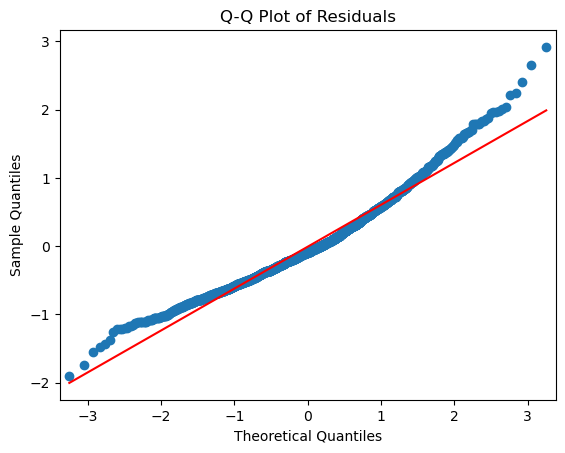

In [67]:
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

C:\Users\Pavilion\AppData\Local\Temp\ipykernel_19876\2665350104.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuals)


<AxesSubplot:xlabel='Value', ylabel='Density'>

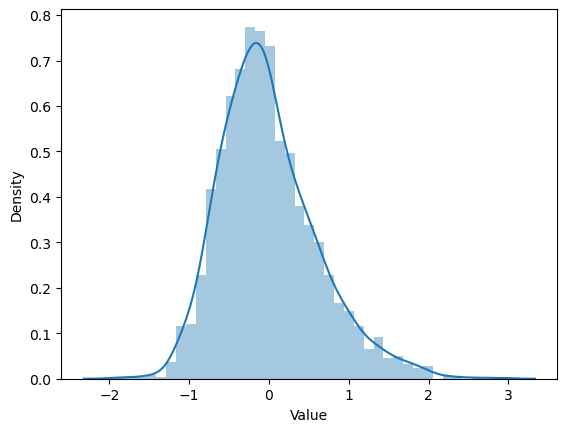

In [68]:
sns.distplot(residuals)

In [69]:
normality_tests(residuals)

Shapiro-Wilk Test: Statistic=0.9686043858528137, p-value=4.81148214855251e-19
Kolmogorov-Smirnov Test: Statistic=0.06973480366733209, p-value=8.077754567497405e-08
Anderson-Darling Test: Statistic=13.883380715635212
At a significance level of 15.0, the critical value is 0.575.
At a significance level of 10.0, the critical value is 0.655.
At a significance level of 5.0, the critical value is 0.785.
At a significance level of 2.5, the critical value is 0.916.
At a significance level of 1.0, the critical value is 1.09.
Lilliefors Test: Statistic=0.06975119302571142, p-value=0.0009999999999998899
D'Agostino's K-squared Test: Statistic=169.9143454762842, p-value=1.2693128647070317e-37


## Homoscedasticity

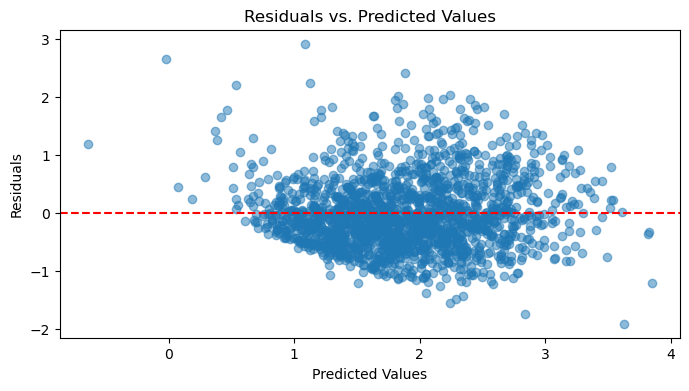

In [70]:
# Residuals vs Predicted values
plt.figure(figsize=(8, 4))
plt.scatter(y_pred, residuals, alpha = 0.5)
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

## Autocorrelation of residuals

The Durbin-Watson test is a statistical test used to detect the presence of autocorrelation (a relationship between values separated from each other by a given time lag) at lag 1 in the residuals (prediction errors) from a regression analysis.The test statistic ranges from 0 to 4.

* A value of 2 indicates no autocorrelation.
* A value approaching 0 indicates positive autocorrelation.
* A value approaching 4 indicates negative autocorrelation.

In [71]:
dw = durbin_watson(residuals)
print(f'Durbin-Watson statistic: {dw}')

Durbin-Watson statistic: 2.0246463443370515


## Milticollinearity

The Variance Inflation Factor (VIF) is a measure that quantifies the extent of multicollinearity in an ordinary least squares regression analysis. Multicollinearity occurs when two or more predictor variables in a regression model are highly correlated, meaning that one can be linearly predicted from the others with a substantial degree of accuracy. 
* VIF = 1: No correlation between the independent variable and the other variables.
* 1 < VIF < 5: Generally, a moderate correlation, and often not of concern.
* VIF >= 5: Indicates high multicollinearity (some sources may use 10 as the threshold), and the variable's coefficients may be poorly estimated due to the redundancy with other predictors.

In [72]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]
print(vif_data)

      feature        VIF
0      MedInc  12.613759
1    HouseAge   7.931287
2    AveRooms  39.154404
3  Population   5.019476
4    AveOccup  13.346055
5   Longitude  55.799216


In [77]:
# Testing model's performance without predictors with high VIF
X_train, X_test, y_train, y_test= train_test_split(df_std.drop(corr_drop+lasso_drop+['Value'
                                                                                     , 'AveRooms'
                                                                                     , 'Longitude']
                                                    , axis=1)
                                                    , df_std["Value"],test_size=0.1
                                                    , shuffle = True, random_state=SEED)
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

regressor = LinearRegression()
regressor.fit(X_train_std, y_train)
y_pred = regressor.predict(X_test_std)
y_pred_train = regressor.predict(X_train_std)
residuals = y_test - y_pred

train_scores = cross_val_score(regressor, X_train_std, y_train, cv=5, scoring='neg_mean_squared_error')
test_mse = mean_squared_error(y_test, y_pred)
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred)

print("Average train MSE:", -np.mean(train_scores))
print(f'Test MSE: {test_mse}')
print(f'Train MAE: {train_mae}')
print(f'Test MAE: {test_mae}')
print(f'Train coefficient of determination: {train_r2}')
print(f'Test coefficient of determination: {test_r2}')

Average train MSE: 0.41006574653162
Test MSE: 0.3989543050113758
Train MAE: 0.49445756549473435
Test MAE: 0.4928465094242139
Train coefficient of determination: 0.4711168903311447
Test coefficient of determination: 0.4763350659026855


# Coefficients

In [74]:
linreg_p_values(regressor, X_train, y_train)

C:\Users\Pavilion\anaconda3\envs\py38\lib\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


,Predictor,coef,t-stat,p-values
0,MedInc,0.403802,110.729464,0.0
1,HouseAge,0.016311,38.971201,0.0
2,Population,0.000125,17.422607,0.0
3,AveOccup,-0.231525,-38.801010,0.0


In [75]:
standardized_coefficients = regressor.coef_
standardized_intercept = regressor.intercept_
original_coefficients = standardized_coefficients / scaler.scale_
original_intercept = standardized_intercept - np.dot(original_coefficients, scaler.mean_)

# Elastic Net

In [78]:
param_grid = {
    'alpha': np.logspace(-4, 4, 10),  # For example: 10 numbers between 10^-4 and 10^4
    'l1_ratio': np.linspace(0.01, 1.0, 10)  # l1_ratio between 0.01 and 1
}


In [79]:
# Initialize a GridSearchCV object
grid = GridSearchCV(estimator=ElasticNet(max_iter=10000), param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid.fit(X, y)

print("Best parameters:", grid.best_params_)
print("Best score MSE:", -grid.best_score_) 

Best parameters: {'alpha': 0.005994842503189409, 'l1_ratio': 0.01}
Best score MSE: 0.5579835279370906


# Polynominal Regression

In [30]:
for i in range(1,7):
    # Create polynomial features
    poly_features = PolynomialFeatures(degree=i, include_bias=False)
    X_poly_train = poly_features.fit_transform(X_train_std)

    # Fit the model
    poly_reg_model = LinearRegression()
    poly_reg_model.fit(X_poly_train, y_train)

    # Predict on training data
    X_poly_test = poly_features.transform(X_test_std)
    y_pred = poly_reg_model.predict(X_poly_test)

    # Calculate and print the mean squared error
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean squared error {i}: {mse}")

Mean squared error 1: 0.3989543050113758
Mean squared error 2: 0.37649242885355627
Mean squared error 3: 0.3607146961700442
Mean squared error 4: 0.34965303342714654
Mean squared error 5: 0.3506620235327232
Mean squared error 6: 0.3439072374732505


In [31]:
# Create polynomial features
poly_features = PolynomialFeatures(degree=4, include_bias=True)
X_poly_train = poly_features.fit_transform(X_train_std)

# Fit the model
poly_reg_model = LinearRegression()
poly_reg_model.fit(X_poly_train, y_train)

# Predict on training data
X_poly_test = poly_features.transform(X_test_std)
y_pred = poly_reg_model.predict(X_poly_test)

# Calculate and print the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean squared error: {mse}")

Mean squared error: 0.349653033427137
